In [67]:
import threading
import cv2
import numpy as np
import pandas as pd
from queue import Queue
from multiprocessing.pool import ThreadPool
from Converter import Convert2D
from imutils.Panorama import Panorama
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt

In [68]:
class HeatmapMaker:

    def __init__(self, data, video, panorama, tracker, threads=5, scaling=1, panorama_name=None, filter=7) -> None:

        if panorama: # panorama not None -> expect data from mobile eyetracker

            if panorama == 'create':
                print("Creating panorama. This can take a while...\n")
                panorama_maker = Panorama(video, panorama_name, (self.world_width // scaling, self.world_height // scaling))
                self.world_panorama = panorama_maker.Create_Panorama()
            else:
                self.world_panorama = cv2.imread(panorama)

            self.pan_height, self.pan_width, _ = self.world_panorama.shape
            self.filter = filter
            self.converter = Convert2D(data, video, self.world_panorama, tracker, threads)
            self.data = self.converter.Get2D()

    def make_heatmap(self):

        heatmap, xedges, yedges = np.histogram2d(self.data['X'], self.data['Y'], bins=(self.pan_width, self.pan_height), range=[[0, self.pan_width], [0, self.pan_height]])
        heatmap *= 255
        heatmap = heatmap.astype(np.uint8).T
        heatmap = gaussian_filter(heatmap, self.filter)
        heatmap = heatmap.astype(np.uint8)

        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HSV)
        heatmap[np.where((heatmap==heatmap[self.panorama.shape[0]][0]).all(axis=2))] = [0, 0, 0]

        return heatmap

In [69]:
map = HeatmapMaker('./pupillabs/gaze_positions.csv', './pupillabs/world.mp4', './pupillabs/panorama.png', 'pupillabs')

heatmap = map.make_heatmap()

TypeError: __init__() missing 1 required positional argument: 'scaling'

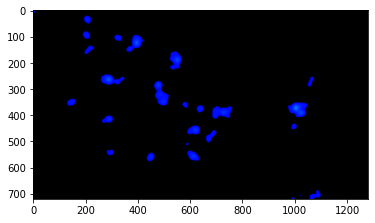

In [ ]:
%matplotlib inline

plt.imshow(heatmap)
plt.show()

In [ ]:
print(heatmap.shape)
print(map.panorama.shape)

(720, 1280, 3)
(689, 1400, 3)


In [ ]:
cv2.addWeighted(map.panorama, 1, heatmap, 1, 0.5)

error: OpenCV(4.5.2) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-ttbyx0jz\opencv\modules\core\src\arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'
